In [1]:
import numpy as np
import enum
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import show

In [59]:
Bateau = dict() # values are [nbr_case, valeur_pixel]
Bateau['porte_avions'] = [5, 10]
Bateau['croiseur'] = [4, 20]
Bateau['contre_torpilleurs'] = [3, 30]
Bateau['sous_marin'] = [3, 40]
Bateau['torpilleur'] = [2, 50]


class Direction(enum.Enum):
    horizontal = 1
    vertical = 2

In [4]:
class Grille():
    def __init__(self, lines=10, cols=10):
        self.grille = np.zeros((lines, cols), dtype=int) # 0 means empty
        self.lines = lines
        self.cols = cols
        
    def peut_placer(self, bateau, position, direction): # position: (ligne, col)
        assert(bateau in Bateau)
        assert(len(position) == 2)
        assert(isinstance(direction, Direction))
        
        try:
            line = position[0]
            column = position[1]
            nbr_case = Bateau[bateau][0]

            if direction.value == Direction.horizontal.value:
                placement = self.grille[line, column:][:nbr_case]
                if sum(placement) == 0 and len(placement) == nbr_case:
                    return True
                return False

            elif direction.value == Direction.vertical.value:
                placement = self.grille[:, column][line:nbr_case + line]
                #print("placement %s => sum = %d", %(placement, sum(placement)))
                if sum(placement) == 0 and len(placement) == nbr_case:
                    return True
                return False

            else:
                raise ValueError("Direction doit etre soit vertical soit horizontal")
        except IndexError:
            return False
    
    def place(self, bateau, position, direction):
        # assertions will be done by peut_placer
        
        if self.peut_placer(bateau, position, direction):
            line = position[0]
            column = position[1]
            
            if direction.value == Direction.horizontal.value:
                self.grille[line, column:][:Bateau[bateau][0]] = Bateau[bateau][1]
            elif direction.value == Direction.vertical.value:
                self.grille[:, column][line:Bateau[bateau][0] + line] = Bateau[bateau][1]
        
            return True
            
        else:
            return False
            
    def place_alea(self, bateau): # need to force termination somehow (it could go +inf)
        random_position = np.random.randint(10, size=2)
        directions = [direction for direction in Direction]
        random_direction = directions[np.random.randint(len(directions))] # returns a direction (type Direction enum)
        
        placed = self.place(bateau, random_position, random_direction)
        """if placed:
            print("successfully place %s at position %s" %(bateau, random_position))"""
        while not placed:
            #print("failed to place %s at position %s " %(bateau, random_position))
            random_position = np.random.randint(10, size=2)
            random_direction = directions[np.random.randint(len(directions))]
            #print("trying again with %s at position %s" %(bateau, random_position))
            placed = self.place(bateau, random_position, random_direction)
            
        """if placed:
            print("successfully place %s at position %s " %(bateau, random_position))
            print(self.grille)"""
            
    def affiche(self):
        plt.imshow(self.grille)
        plt.set_cmap('hot')
        
    def eq(self, grilleB): # u might need to fix this
        return self.grille == grilleB.grille
    
    def genere_grille(self):
        for bateau in Bateau:
            #print(bateau)
            self.place_alea(bateau)
            
    def remove_ship(self, ship, position, direction):
        line = position[0]
        column = position[1]
        nbr_case = Bateau[ship][0]
        
        if direction.value == Direction.horizontal.value:
            self.grille[line, column:][:nbr_case] = 0
            
        elif direction.value == Direction.vertical.value:
            self.grille[:, column][line:nbr_case + line] = 0

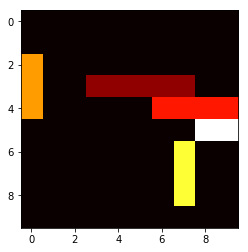

In [5]:
grille = Grille()
grille.genere_grille()
grille.affiche()

## 2 Combinatoire du jeu

Donner une borne supérieure du nombre de configurations possibles pour la liste
complète de bateaux sur une grille de taille 10 (calcul à la main).

In [6]:
# fonction qui permet de dénombrer le nombre de façons de placer un bateau donné sur une grille vide
def how_many_ways_to_put(grid, ship_len, lines):
    """
        Assumption: the grid is represented as a SQUARE matrix
        
        @params: grid 
                 ship_len -> longueur du bateau 
                 lines -> number of lines in the grid
    """
    assert(isinstance(grid, Grille))
    assert(isinstance(ship_len, int) and ship_len > 0)
    
    #grid = Grille(lines, lines)
    count = 0
    Bateau['temp'] = [ship_len, 100]
    
    for i in range(lines):
        for j in range(lines):
            if grid.peut_placer('temp', (i,j), Direction.horizontal):
                count += 1
            
            if grid.peut_placer('temp', (i,j), Direction.vertical):
                count += 1
    
    del Bateau['temp']
    
    return count

In [58]:
def construct_ships(ships_length, colors=None):
    ships = []
    i = 0
    
    for ship_len in ships_length: 
        color = np.random.randint(10, 150)
        ship_name = str(ship_len + color) + 'D' + str(ships_length.count(ship_len))
        ships.append(ship_name)
        
        if colors is not None:
            Bateau[ship_name] = [ship_len, colors[i]]
            i += 1
        else:
            Bateau[ship_name] = [ship_len, color] 
    
    return ships

In [22]:
def calculate(grid, ships, lines, cols, count, visualize):    
    
    if len(ships) == 1:
        for i in range(lines):
            for j in range(cols):
                for direction in Direction:
                    if grid.peut_placer(ships[0], (i,j), direction):
                        
                        if visualize:
                            grid.place(ships[0], (i,j), direction)
                            grid.affiche()
                            show()
                            grid.remove_ship(ships[0], (i,j), direction)
                            
                        count += 1
                            
    else:
        for i in range(lines):
            for j in range(cols):
                for direction in Direction:
                    if grid.peut_placer(ships[0], (i,j), direction):
                        grid.place(ships[0], (i,j), direction)
                        count = calculate(grid, ships[1:], lines, cols, count, visualize)
                        
                        if count % 3 == 0:
                            sys.stdout.write("\r%d" % count)
                            sys.stdout.flush()
                        grid.remove_ship(ships[0], (i,j), direction)
                            
    return count

In [23]:
# fonction qui permet de dénombrer le nombre de façon de placer une liste de bateaux sur une grille vide. 
def how_many_conf(ships_length, lines, cols, visualize = False):
    grid = Grille(lines, cols)
    ships = construct_ships(ships_length)
    
    count = calculate(grid, ships, lines, cols, 0, visualize)
    
    for ship in ships:
        try:
            del Bateau[ship]
        except KeyError:
            pass
        
    return count

In [29]:
how_many_conf([3,3], 3, 3)

12

12

In [74]:
def how_much_to_get_grid(grid):
    # fonction qui prend enparamètre une grille, génère des grilles aléatoirement jusqu’à ce que la grille 
    # générée soit égale à la grille passée en paramètre et qui renvoie le nombre de grilles générées.
    count = 1
    
    # constructing new ships with the same lengths and colors
    uniq, counts = (np.unique(grid.grille, return_counts=True))
    
    ships = dict(zip(uniq[1:], counts[1:]))
    ships = construct_ships(list(ships.values()), list(ships.keys()))
    
    # constructing new grids
    tmp = Grille(grid.lines, grid.cols)
    is_the_same = False
    
    for ship in ships:
        tmp.place_alea(ship)
        
    if (tmp.grille == grid.grille).all():
        is_the_same = True
        
    while not is_the_same:
        count += 1
        
        tmp = Grille(grid.lines, grid.cols)

        for ship in ships:
            tmp.place_alea(ship)

        if (tmp.grille == grid.grille).all():
            is_the_same = True
    
    # deleting temp ships
    
    for ship in ships:
        try:
            del Bateau[ship]
        except KeyError:
            pass
        
    return count